In [1]:
import sys,os
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
import netCDF4 as netcdf
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('..'))
# module_path = os.path.join(os.path.abspath(os.path.join('..')),'wgpack')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from wgpack.nav import get_bearing
# from wgpack.config import RDRPATH,seachest_data_dir
# from wgpack.adcp import readADCP_raw,motion_correct_ADCP_gps_h5py
# from wgpack.timeconv import datetime2matlabdn
# from wgpack.helperfun import nan_interpolate
from wgpack.config import seachest_data_dir
datadir  = os.path.join(os.path.dirname(seachest_data_dir),'ARCTERX2022/forecasts')

# Data service path
ds_folder = os.path.join(str(Path.home()),'src/lri-wgms-data-service')
if ds_folder not in sys.path:
    sys.path.insert(0, ds_folder)
from DataService import DataService

# inputs:
vnam,channels,tw,prj =  'sv3-251','C0158P2JJTT','4','westpac'


/Users/a1amador/src/wgpack


In [2]:

# --------------------------------------------------------
# Set start date according to the time window to be considered
now = datetime.utcnow()
if tw is not None:
    # use specified time window
    tst = now - pd.Timedelta(days=float(tw))
else:
    # use last 7 days
    tst = now - pd.Timedelta(days=7)
    

In [3]:
# Read in vehicle location from Data Service
# try:
# instantiate data-service object
ds = DataService()
# To get report names
# print(ds.report_list)

start_date = tst.strftime("%Y-%m-%dT%H:%M:%S.000Z")
end_date = now.strftime("%Y-%m-%dT%H:%M:%S.000Z")
out = ds.get_report_data('Telemetry 6 Report', start_date, end_date, [vnam])
# Convert to pandas dataframe
Telemdf = pd.json_normalize(out['report_data'][0]['vehicle_data']['recordData'])
# set timeStamp column as datetimeindex
Telemdf = Telemdf.set_index(pd.DatetimeIndex(Telemdf['gliderTimeStamp'].values))
Telemdf.drop(columns=['gliderTimeStamp'], inplace=True)
# sort index
Telemdf.sort_index(inplace=True)

Index(['surfaceTemperature', 'latitude', 'longitude', 'lastLocationFix',
       'temperatureSub', 'iridiumSignalStrength', 'targetWayPoint',
       'gliderHeading', 'gliderDistance', 'gliderSpeed', 'shoreSideCreated',
       'desiredBearingDegrees', 'headingFloatDegrees', 'headingSubDegrees',
       'pressureSensorFloat', 'lightState', 'distanceOverGround',
       'speedOverGround', 'oceanCurrent', 'oceanCurrentDirection'],
      dtype='object')


(-0.32554056237739676, 6.869544464935873, -1.4854154057582, 6.993743768050201)

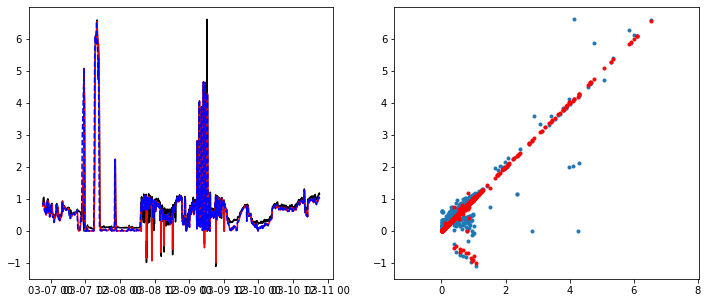

In [4]:
from geopy.distance import distance
kt2mps = 0.514444

print(Telemdf.keys())

sog_lonlat,cog_lonlat=[],[]
cc=0
for index, row in Telemdf[:-1].iterrows():
    cc+=1
    p1 = (row['latitude'],row['longitude'])
    p2 = (Telemdf.iloc[cc]['latitude'],Telemdf.iloc[cc]['longitude'])
    delt = (Telemdf.index[cc]-index)/np.timedelta64(1, 's')
    sogtmp = distance(p1,p2).m/delt if delt>0 else np.nan 
    sog_lonlat.append(sogtmp)
    cog_lonlat.append(get_bearing(p1,p2))

# ---------------------------------------------------------
# plot results
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(Telemdf['speedOverGround']*kt2mps,'k')
ax[0].plot(Telemdf['gliderSpeed']*kt2mps,'r')
ax[0].plot(Telemdf.index[:-1],sog_lonlat,'--b')

ax[1].plot(sog_lonlat,Telemdf['speedOverGround'].values[1:]*kt2mps,'.')
ax[1].plot(sog_lonlat,Telemdf['gliderSpeed'].values[1:]*kt2mps,'.r')
ax[1].axis('equal')

In [5]:
# LOAD ROMS data

try:
    # filename
    filename = 'ROMS_Guam_' + datetime.utcnow().strftime('%Y%m%d') + '.ncd'
    dfnam    = os.path.join(datadir,filename)
    init_str = datetime.utcnow().strftime('%Y-%m_%d') + ' UTC'
    # Read-in data
    ROMS_data = netcdf.Dataset(dfnam)
except FileNotFoundError as err:
    print(err)
    # filename (previous day)
    filename = 'ROMS_Guam_' + (datetime.utcnow()- pd.Timedelta(days=1)).strftime('%Y%m%d') + '.ncd'
    dfnam    = os.path.join(datadir,filename)
    init_str = (datetime.utcnow()- pd.Timedelta(days=1)).strftime('%Y-%m_%d') + ' UTC'
    # Read-in data
    ROMS_data = netcdf.Dataset(dfnam)


In [6]:
# get surface layer velocities near the Wave Glider
# depth
sub_depth = 8
iida = ROMS_data['depth'][:]<(sub_depth+2)
# find nearest ROMS point to WG location
iilonWG = np.abs(ROMS_data['lon'][:]-Telemdf['longitude'].values[-1]).argmin()
iilatWG = np.abs(ROMS_data['lat'][:]-Telemdf['latitude'].values[-1]).argmin()
# Grid points to show
nii = 20 # number of grid points
iiL = min(len(ROMS_data['lon'][:]),len(ROMS_data['lat'][:]))
iia_lon = max(iilonWG-nii,0)
iib_lon = min(iilonWG+nii,iiL)
iia_lat = max(iilatWG-nii,0)
iib_lat = min(iilatWG+nii,iiL)
# find nearest time interval
print(ROMS_data['time'].units)
match = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', ROMS_data['time'].units)
basetime = pd.to_datetime(datetime.strptime(match.group(), '%Y-%m-%d %H:%M:%S').date())
ttsim = []
for hh in ROMS_data['time'][:]:
    ttsim.append(basetime+pd.Timedelta(hours=hh))
ttsim = pd.to_datetime(ttsim)
iit = np.abs(ttsim-Telemdf.index[-1]).argmin()

# get data
u_sl = np.mean(ROMS_data['u'][iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=0)
v_sl = np.mean(ROMS_data['v'][iit, iida, iia_lat:iib_lat, iia_lon:iib_lon],axis=0)
lon_ROMS = ROMS_data['lon'][iia_lon:iib_lon]
lat_ROMS = ROMS_data['lat'][iia_lat:iib_lat]
# compute velocity magnitude
vel_mag = np.sqrt(u_sl**2+v_sl**2)

hours since 2015-04-15 00:00:00.000 UTC


/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


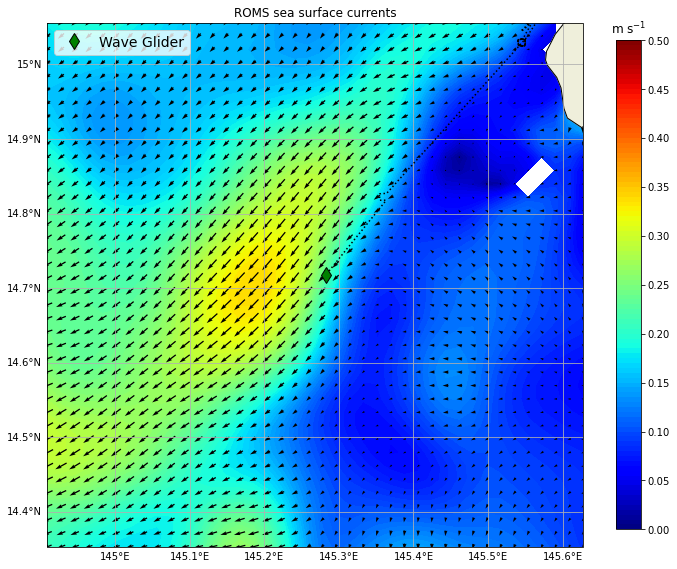

In [7]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

scale = 0.3
isub = 3
levels = np.linspace(0,0.50,101)
fntsz = 14



fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

ax.set_extent([lon_ROMS.min(), lon_ROMS.max(), lat_ROMS.min(), lat_ROMS.max()])
ax.add_feature(LAND)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_ROMS, lat_ROMS, vel_mag,levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
# Q = ax.quiver(lon, lat, u_sl, v_sl, 
#         scale=1.0/scale, pivot='middle', zorder=1e35, width=0.003)
Q = ax.quiver(lon_ROMS, lat_ROMS, u_sl, v_sl, pivot='middle')
# legend_str='%3.1f m/s' % legend_vel
# qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75,ticks=np.linspace(0,0.50,11))
cb.ax.set_title('m s$^{-1}$')
ax.set_title('ROMS sea surface currents');




In [8]:
# LOAD WRF data

try:
    # filename
    filename = 'WRF_Guam_' + datetime.utcnow().strftime('%Y%m%d') + '.ncd'
    dfnam    = os.path.join(datadir,filename)
    init_str = datetime.utcnow().strftime('%Y-%m_%d') + ' UTC'
    # Read-in data
    WRF_data = netcdf.Dataset(dfnam)
except FileNotFoundError as err:
    print(err)
    # filename (previous day)
    filename = 'WRF_Guam_' + (datetime.utcnow()- pd.Timedelta(days=1)).strftime('%Y%m%d') + '.ncd'
    dfnam    = os.path.join(datadir,filename)
    init_str = (datetime.utcnow()- pd.Timedelta(days=1)).strftime('%Y-%m_%d') + ' UTC'
    # Read-in data
    WRF_data = netcdf.Dataset(dfnam)

WRF_data.variables


{'Pair': <class 'netCDF4._netCDF4.Variable'>
 float32 Pair(time, lat, lon)
     units: millibar
     long_name: surface air pressure
     coordinates: time_run time lat lon 
     time: time
     _ChunkSizes: [  1 148 148]
     standard_name: surface_air_pressure
     _CoordinateAxisType: Pressure
 unlimited dimensions: 
 current shape = (121, 148, 148)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time_run': <class 'netCDF4._netCDF4.Variable'>
 float64 time_run(time)
     long_name: run times for coordinate = time
     standard_name: forecast_reference_time
     calendar: proleptic_gregorian
     units: hours since 2013-06-14 00:00:00.000 UTC
     missing_value: nan
     _CoordinateAxisType: RunTime
 unlimited dimensions: 
 current shape = (121,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     long_name: Forecast time for ForecastModelRunCollection
     standard_name: time
     calen

In [9]:
# get 10-m wind velocities near the Wave Glider
# find nearest WRF point to WG location
iilonWG = np.abs(WRF_data['lon'][:]-Telemdf['longitude'].values[-1]).argmin()
iilatWG = np.abs(WRF_data['lat'][:]-Telemdf['latitude'].values[-1]).argmin()
# Grid points to show
nii = 20 # number of grid points
iiL = min(len(WRF_data['lon'][:]),len(WRF_data['lat'][:]))
iia_lon = max(iilonWG-nii,0)
iib_lon = min(iilonWG+nii,iiL)
iia_lat = max(iilatWG-nii,0)
iib_lat = min(iilatWG+nii,iiL)
# find nearest time interval
print(WRF_data['time'].units)
match = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', WRF_data['time'].units)
basetime = pd.to_datetime(datetime.strptime(match.group(), '%Y-%m-%d %H:%M:%S').date())
ttsim = []
for hh in WRF_data['time'][:]:
    ttsim.append(basetime+pd.Timedelta(hours=hh))
ttsim = pd.to_datetime(ttsim)
iit = np.abs(ttsim-Telemdf.index[-1]).argmin()

# get data
u10 = WRF_data['Uwind'][iit, iia_lat:iib_lat, iia_lon:iib_lon]
v10 = WRF_data['Vwind'][iit, iia_lat:iib_lat, iia_lon:iib_lon]
lon_WRF = WRF_data['lon'][iia_lon:iib_lon]
lat_WRF = WRF_data['lat'][iia_lat:iib_lat]
# # compute velocity magnitude
u10_mag = np.sqrt(u10**2+v10**2)

iit

hours since 2013-06-14 00:00:00.000 UTC


21

/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


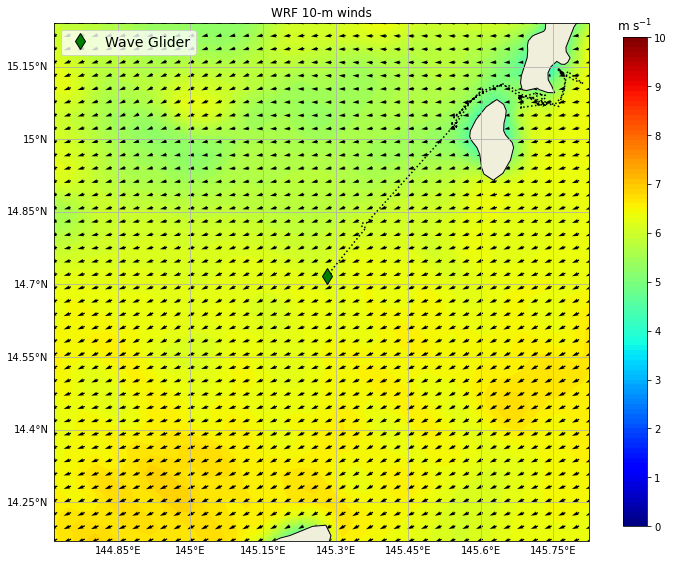

In [10]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

scale = 0.3
isub = 3
levels = np.linspace(0,10,101)
fntsz = 14



fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

ax.set_extent([lon_WRF.min(), lon_WRF.max(), lat_WRF.min(), lat_WRF.max()])
ax.add_feature(LAND)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_WRF, lat_WRF, u10_mag,levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = ax.quiver(lon_WRF, lat_WRF, u10, v10, pivot='middle')
# legend_str='%3.1f m/s' % legend_vel
# qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75,ticks=np.linspace(0,10,11))
cb.ax.set_title('m s$^{-1}$')
ax.set_title('WRF 10-m winds');




'2022-03_09 UTC'

In [35]:
# LOAD WW3 data

try:
    # filename
    filename = 'WaveWatch_III_Mariana_' + datetime.utcnow().strftime('%Y%m%d') + '.ncd'
    dfnam    = os.path.join(datadir,filename)
    init_str = datetime.utcnow().strftime('%Y-%m_%d') + ' UTC'
    # Read-in data
    WW3_data = netcdf.Dataset(dfnam)
except FileNotFoundError as err:
    print(err)
    # filename (previous day)
    filename = 'WaveWatch_III_Mariana_' + (datetime.utcnow()- pd.Timedelta(days=1)).strftime('%Y%m%d') + '.ncd'
    dfnam    = os.path.join(datadir,filename)
    init_str = (datetime.utcnow()- pd.Timedelta(days=1)).strftime('%Y-%m_%d') + ' UTC'
    # Read-in data
    WW3_data = netcdf.Dataset(dfnam)

WW3_data.variables



{'Tdir': <class 'netCDF4._netCDF4.Variable'>
 float32 Tdir(time, z, lat, lon)
     units: degrees
     long_name: peak wave direction
     standard_name: sea_surface_wave_from_direction
     short_name: Tdir
     valid_range: [  0. 360.]
     _FillValue: nan
     coordinates: time_run time z lat lon 
 unlimited dimensions: 
 current shape = (67, 1, 71, 61)
 filling on,
 'time_run': <class 'netCDF4._netCDF4.Variable'>
 float64 time_run(time)
     long_name: run times for coordinate = time
     standard_name: forecast_reference_time
     calendar: proleptic_gregorian
     units: hours since 2012-05-16 00:00:00.000 UTC
     missing_value: nan
     _CoordinateAxisType: RunTime
 unlimited dimensions: 
 current shape = (67,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     long_name: Forecast time for ForecastModelRunCollection
     standard_name: time
     calendar: proleptic_gregorian
     units: hours sinc

In [12]:
# get bulk wave params near the Wave Glider

# find nearest WW3 point to WG location
iilonWG = np.abs(WW3_data['lon'][:]-Telemdf['longitude'].values[-1]).argmin()
iilatWG = np.abs(WW3_data['lat'][:]-Telemdf['latitude'].values[-1]).argmin()
# Grid points to show
nii = 9 # number of grid points
iiL = min(len(WW3_data['lon'][:]),len(WW3_data['lat'][:]))
iia_lon = max(iilonWG-nii,0)
iib_lon = min(iilonWG+nii,iiL)
iia_lat = max(iilatWG-nii,0)
iib_lat = min(iilatWG+nii,iiL)
# find nearest time interval
print(WW3_data['time'].units)
match = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', WW3_data['time'].units)
basetime = pd.to_datetime(datetime.strptime(match.group(), '%Y-%m-%d %H:%M:%S').date())
ttsim = []
for hh in WW3_data['time'][:]:
    ttsim.append(basetime+pd.Timedelta(hours=hh))
ttsim = pd.to_datetime(ttsim)
iit = np.abs(ttsim-Telemdf.index[-1]).argmin()

# get data
# peak wave direction (time, z, lat, lon)
Dp = WW3_data['Tdir'][iit,0,iia_lat:iib_lat,iia_lon:iib_lon]
# compute wave direction components (based on Dp)
uw = -np.sin(Dp*np.pi/180)
vw = -np.cos(Dp*np.pi/180)
# significant wave height (time, z, lat, lon)
Hs = WW3_data['Thgt'][iit,0,iia_lat:iib_lat,iia_lon:iib_lon]
# peak wave period (time, z, lat, lon)
Tp = WW3_data['Tper'][iit,0,iia_lat:iib_lat,iia_lon:iib_lon]
# coordinates
lon_WW3 = WW3_data['lon'][iia_lon:iib_lon]
lat_WW3 = WW3_data['lat'][iia_lat:iib_lat]


iit
Hs.shape

hours since 2012-05-16 00:00:00.000 UTC


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_88362/2176706876.py:27: RuntimeWarning: invalid value encountered in sin
  uw = -np.sin(Dp*np.pi/180)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_88362/2176706876.py:28: RuntimeWarning: invalid value encountered in cos
  vw = -np.cos(Dp*np.pi/180)


(18, 18)

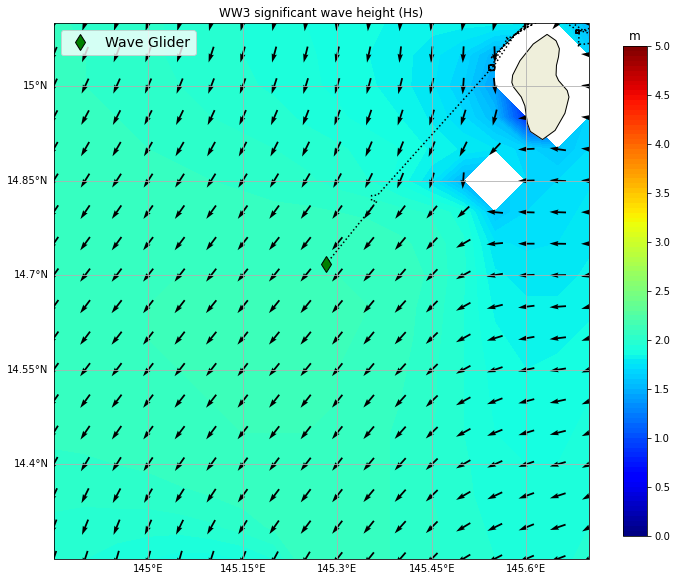

In [15]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

scale = 0.3
isub = 3
levels = np.linspace(0,5,101)
fntsz = 14



fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

ax.set_extent([lon_WW3.min(), lon_WW3.max(), lat_WW3.min(), lat_WW3.max()])
ax.add_feature(LAND)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_WW3, lat_WW3, Hs,levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = ax.quiver(lon_WW3, lat_WW3, uw, vw, pivot='middle')
# legend_str='%3.1f m/s' % legend_vel
# qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75,ticks=np.linspace(levels[0],levels[-1],11))
# cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('m')
ax.set_title('WW3 significant wave height (Hs)');




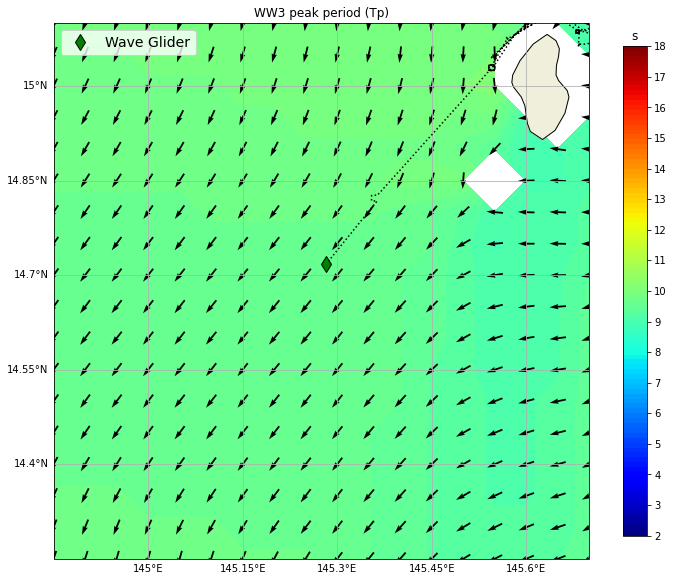

In [18]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

scale = 0.3
isub = 3
levels = np.linspace(2,18,101)
fntsz = 14



fig, ax = plt.subplots(figsize=(12,12), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

ax.set_extent([lon_WW3.min(), lon_WW3.max(), lat_WW3.min(), lat_WW3.max()])
ax.add_feature(LAND)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = ax.contourf(lon_WW3, lat_WW3, Tp,levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
ax.plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
ax.plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label='Wave Glider')
ax.legend(fontsize=fntsz,loc='upper left')
# tick params
ax.tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = ax.quiver(lon_WW3, lat_WW3, uw, vw, pivot='middle')
# legend_str='%3.1f m/s' % legend_vel
# qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75,ticks=np.linspace(levels[0],levels[-1],17))
# cb = plt.colorbar(cf, shrink=0.75)
cb.ax.set_title('s')
ax.set_title('WW3 peak period (Tp)');



/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/a1amador/opt/miniconda3/envs/wgpack/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Pleas

Text(0.5, 0.945, 'sv3-251: PacIOOS forecasts for 2022-03-10, 21:12 UTC\nInitialized 2022-03_10 UTC')

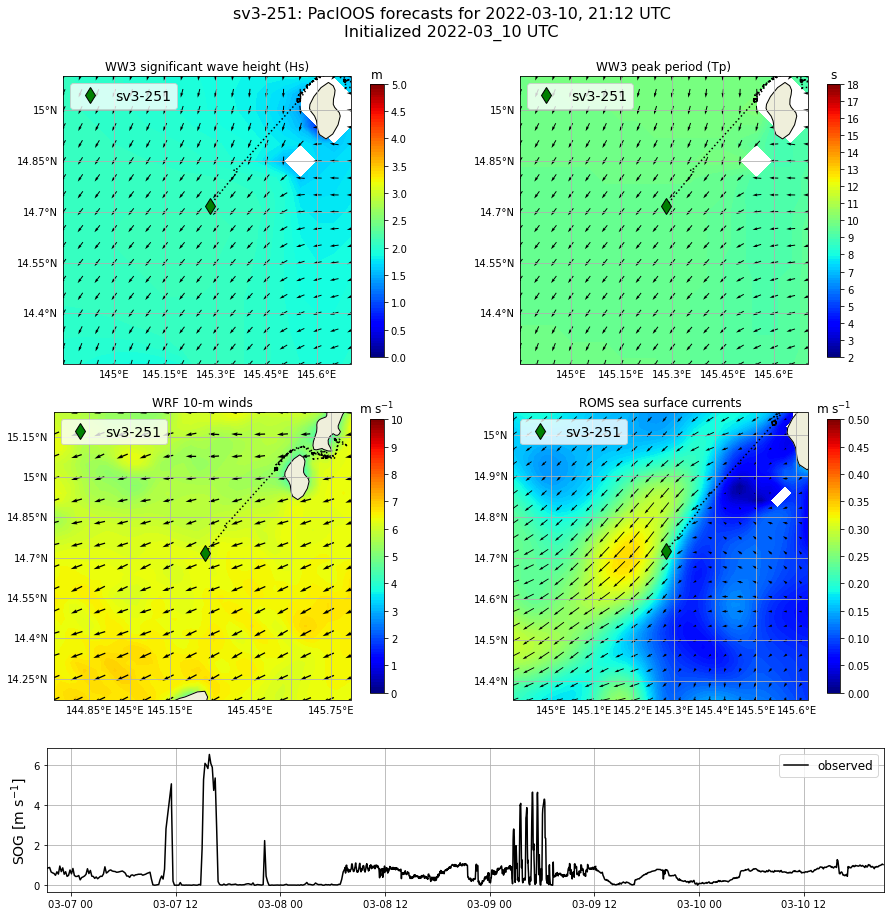

In [37]:
# Bringing it all together
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec


# configure plot parameters
labsz = 12
fntsz = 14
# xL = (WXTdf_bar.index[0],WXTdf_bar.index[-1])
widths = [1, 1]
heights = [1, 1, 0.5]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

# configure general Cartopy parameters
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

fig, axd = plt.subplot_mosaic([['ax1', 'ax2'], ['ax3', 'ax4'], ['ax5', 'ax5']], gridspec_kw=gs_kw,
                              figsize=(15, 15), subplot_kw=dict(projection=ccrs.PlateCarree()))
# fig, ax = plt.subplots(3, 2, gridspec_kw=gs_kw, figsize=(15, 15))

# --------------------------------------------------------------------------------------------
# Hs
# --------------------------------------------------------------------------------------------
# config for Hs
isub = 1
levels = np.linspace(0,5,101)

# ax[1] = fig.add_subplot(gs[0:2, :], projection=ccrs.PlateCarree())
# axd['ax1'] = plt.axes(projection=ccrs.PlateCarree())
axd['ax1'].set_extent([lon_WW3.min(), lon_WW3.max(), lat_WW3.min(), lat_WW3.max()])
axd['ax1'].add_feature(LAND)
axd['ax1'].coastlines(resolution='10m')
gl = axd['ax1'].gridlines(draw_labels=True)
# gl.xlabels_top = axd['ax1'].ylabels_right = False
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = axd['ax1'].contourf(lon_WW3, lat_WW3, Hs, levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
axd['ax1'].plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
axd['ax1'].plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label=vnam)
axd['ax1'].legend(fontsize=fntsz,loc='upper left')
# tick params
axd['ax1'].tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = axd['ax1'].quiver(lon_WW3, lat_WW3, uw, vw, pivot='middle')

# colorbar and labels
cb = fig.colorbar(cf, ax=axd['ax1'], shrink=0.95,ticks=np.linspace(levels[0],levels[-1],11))
cb.ax.set_title('m')
axd['ax1'].set_title('WW3 significant wave height (Hs)');

# --------------------------------------------------------------------------------------------
# Tp
# --------------------------------------------------------------------------------------------
# config for Tp
isub = 1
levels = np.linspace(2,18,101)

axd['ax2'].set_extent([lon_WW3.min(), lon_WW3.max(), lat_WW3.min(), lat_WW3.max()])
axd['ax2'].add_feature(LAND)
axd['ax2'].coastlines(resolution='10m')
gl = axd['ax2'].gridlines(draw_labels=True)
# gl.xlabels_top = axd['ax1'].ylabels_right = False
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = axd['ax2'].contourf(lon_WW3, lat_WW3, Tp, levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
axd['ax2'].plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
axd['ax2'].plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label=vnam)
axd['ax2'].legend(fontsize=fntsz,loc='upper left')
# tick params
axd['ax2'].tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = axd['ax2'].quiver(lon_WW3, lat_WW3, uw, vw, pivot='middle')

# colorbar and labels
cb = fig.colorbar(cf, ax=axd['ax2'], shrink=0.95,ticks=np.linspace(levels[0],levels[-1],17))
cb.ax.set_title('s')
axd['ax2'].set_title('WW3 peak period (Tp)');

# --------------------------------------------------------------------------------------------
# Wind speed
# --------------------------------------------------------------------------------------------
# config for u10
isub = 3
levels = np.linspace(0,10,101)

axd['ax3'].set_extent([lon_WRF.min(), lon_WRF.max(), lat_WRF.min(), lat_WRF.max()])
axd['ax3'].add_feature(LAND)
axd['ax3'].coastlines(resolution='10m')
gl = axd['ax3'].gridlines(draw_labels=True)
# gl.xlabels_top = axd['ax1'].ylabels_right = False
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = axd['ax3'].contourf(lon_WRF, lat_WRF, u10_mag, levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
axd['ax3'].plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
axd['ax3'].plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label=vnam)
axd['ax3'].legend(fontsize=fntsz,loc='upper left')
# tick params
axd['ax3'].tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = axd['ax3'].quiver(lon_WRF[::isub], lat_WRF[::isub], u10[::isub,::isub], v10[::isub,::isub], pivot='middle')

# colorbar and labels
cb = fig.colorbar(cf, ax=axd['ax3'], shrink=0.95,ticks=np.linspace(levels[0],levels[-1],11))
cb.ax.set_title('m s$^{-1}$')
axd['ax3'].set_title('WRF 10-m winds');

# --------------------------------------------------------------------------------------------
# Currents
# --------------------------------------------------------------------------------------------
# config for u10
isub = 2
levels = np.linspace(0,0.5,101)

axd['ax4'].set_extent([lon_ROMS.min(), lon_ROMS.max(), lat_ROMS.min(), lat_ROMS.max()])
axd['ax4'].add_feature(LAND)
axd['ax4'].coastlines(resolution='10m')
gl = axd['ax4'].gridlines(draw_labels=True)
# gl.xlabels_top = axd['ax1'].ylabels_right = False
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# contour plot
cf = axd['ax4'].contourf(lon_ROMS, lat_ROMS, vel_mag, levels=levels, cmap='jet',
                 transform=ccrs.PlateCarree())

# plot Wave Glider location
axd['ax4'].plot(Telemdf['longitude'].values,Telemdf['latitude'].values,':k')
axd['ax4'].plot(Telemdf['longitude'].values[-1],Telemdf['latitude'].values[-1],'gd',mec='k',ms=12, label=vnam)
axd['ax4'].legend(fontsize=fntsz,loc='upper left')
# tick params
axd['ax4'].tick_params(labelsize=fntsz)

# Quiver plot
legend_vel=1.0
Q = axd['ax4'].quiver(lon_ROMS[::isub], lat_ROMS[::isub], u_sl[::isub,::isub], v_sl[::isub,::isub], pivot='middle')

# colorbar and labels
cb = fig.colorbar(cf, ax=axd['ax4'], shrink=0.95,ticks=np.linspace(levels[0],levels[-1],11))
cb.ax.set_title('m s$^{-1}$')
axd['ax4'].set_title('ROMS sea surface currents');

# --------------------------------------------------------------------------------------------
# Vehicle SOG
# --------------------------------------------------------------------------------------------
fig.delaxes(axd['ax5'])
gs = fig.add_gridspec(ncols=2, nrows = 3,width_ratios=widths, height_ratios=heights)
ax = fig.add_subplot(gs[-1, :])
ax.plot(Telemdf.index[:-1],sog_lonlat,'-k',label='observed')
ax.set_ylabel('SOG [m s$^{-1}$]',fontsize=fntsz)
ax.legend(fontsize=labsz)
ax.set_xlim(Telemdf.index[0],Telemdf.index[-1])
ax.grid(':')


# Add a big title at the top
# fig.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts', y=0.925)
tmstmp = now.strftime('%Y-%m-%d, %H:%M UTC')
fig.suptitle(vnam + ': PacIOOS forecasts for ' + tmstmp + '\nInitialized ' +init_str, fontsize=fntsz+2, y=0.945)
